## QUESTION 25: Idea 3 - PageRank

> PageRank is a classic algorithm originally developed by Google, to rank web pages in search engine results.

> A page is important if many important pages link to it.

We can find the personalized PageRank of each document in seven different runs, one per class.  
In each run, select one of the classes and take the 20 seed documents of that class. Then,   perform a random walk with the following customized properties:  

- (a) teleportation takes the random walker to one of the seed documents of that class (with a uniform probability of 1/20 per seed document).  
Vary the **teleportation probability** in **{0, 0.1, 0.2}**.  

- (b) the probability of transitioning to neighbors is not uniform among the neighbors. Rather, it is proportional to the **cosine similarity** between the text features of the current node and the next neighboring node.  

Particularly, assume we are currently visiting a document \( $x_0$ \) which has neighbors \( $x_1$, $x_2$, $x_3$ \).

Then the probability of transitioning to each neighbor is:

$$
p_i = \frac{\exp(x_0 \cdot x_i)}{\exp(x_0 \cdot x_1) + \exp(x_0 \cdot x_2) + \exp(x_0 \cdot x_3)} ; \quad \text{for } i = 1, 2, 3.
$$

*Repeat part b for every teleportation probability in part a*. (i.e., 6 experiments)

Run the PageRank only on the GCC. For each seed node, do <u> 1000 random walks</u>. Maintain a class-wise visited frequency count for every unlabeled node. The predicted class for that   unlabeled node is the class which lead to maximum visits to that node. **Report accuracy and f1 scores**.

For example if node `n` was visited by 7 random walks from class A, 6 random walks from class B... 1 random walk from class G, then the predicted label of node `n` is class A.

Resource:
- NetworkX-pagerank: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html
- https://stats.stackexchange.com/questions/496646/markov-transition-matrix-row-sums-to-1
- https://langvillea.people.charleston.edu/DISSECTION-LAB/ClarePageRankModule/6_Mathematics.html

In [26]:
!pip install tqdm-joblib

In [27]:
import numpy as np
import os
import networkx as nx
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report
from numpy import dot
from numpy.linalg import norm
from collections import Counter
import matplotlib.pyplot as plt
# added
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
import time
import random
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score
from typing import Tuple, List
from sklearn.linear_model import LogisticRegression


In [28]:
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/Colab\ Notebooks/Part3_Cora_Dataset/cora
import os
print(os.listdir())

['cora_gcn_helper.ipynb', '.DS_Store', 'ECE232_submissionpdf.pdf', 'gplus', 'project_2_part3_Cora.ipynb', 'temp.ipynb', 'facebook_combined.txt', 'ECE232_Google+.ipynb', 'cora', 'ECE232_Facebook_network.ipynb', 'ECE232_Cora.ipynb', 'data']


One of the well-known categories of machine learning problems is “supervised learning”. In supervised learning we are given some information called “input” features about certain objects.

For each object, we are also given an “output” or target variable that we are trying to predict about. Our goal is to learn the mapping between the features and the target variable.

Typically, there is a portion of data where both input features and target variables are available. This portion of the dataset is called the *training set*. There is also typically another portion of the dataset where the target variable is missing and we want to predict it. This portion is called the “*test set*”.

When the target variable can take on a finite number of discrete values, we call the problem at hand a “classification” problem. In this project, we are trying to solve a classification problem in settings where some additional information is provided in the form of “graph structure”. In this project we work with “Cora” dataset. Cora consists of a set of 2708 documents that are Machine Learning related papers. Each documents is labeled with one of the following seven classes: Case Based, Genetic Algorithms, Neural Networks, Probabilistic Methods, Reinforcement Learning, Rule Learning, Theory. For each class, only 20 documents are labeled (a total of 140 for the seven classes). We refer to them as “seed” documents. Each document comes with a set of features about its text content. These features are occurrences of a selection of 1433 words in the vocabulary. We are also given an undirected graph where each node is a document and each
edge represents a citation. There are a total of 5429 edges.
Our goal is to use the hints from text features as well as from graph connections to classify (assign labels to) these documents.

To solve this problem for Cora dataset, we pursue three parallel ideas. Implement each idea and compare.

**Summary of the dataset:**

Link: https://linqs.org/datasets/#cora

Total 2708 documents.

7 labels, each with 20 documents (seed) -> total 140 for 7 classes. 20 train instances per class

1433 Features (occurences of 1433 words)


In [30]:
# cora.content: format of each line
#   node_id feat1 feat2 ... feat1433 label
# cora.cites: format of each line
#   source_node_id target_node_id

In [31]:
# Code Source from the Bruinlearn
def is_running_on_colab():
    return 'google.colab' in sys.modules

if is_running_on_colab():
    cora_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Part3_Cora_Dataset/cora'
else:
    cora_dataset_path = './cora'

all_data = []   # store each line from cora.content (node features + labels)
all_edges = []  # store each line from cora.cites (citation edges)

for root, dirs, files in os.walk(cora_dataset_path):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_edges.extend(f.read().splitlines())

print("Number of nodes:", len(all_data))
print(all_data[0])    
# from sklearn.utils import shuffle
# all_data = shuffle(all_data, random_state=42)

Number of nodes: 2708
31336	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

In [32]:
# map <category, label>
categories = [
    'Case_Based',
    'Genetic_Algorithms',
    'Neural_Networks',
    'Probabilistic_Methods',
    'Reinforcement_Learning',
    'Rule_Learning',
    'Theory'
]

label_encoder, i = {}, 0
for cat in sorted(categories):
  label_encoder[cat] = i
  i +=1
label_encoder

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [33]:
# parse the data
nodes, labels = [], []
X = []
element_to_ind  = {}

for i, data in enumerate(all_data):
    elements = data.split('\t')
    curr_node, curr_feature, curr_label = elements[0], elements[1:-1], label_encoder[elements[-1]]
    nodes.append(curr_node)
    X.append(curr_feature)
    labels.append(curr_label)
    element_to_ind[curr_node]= i

X = np.array(X, dtype=int)


# parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print(f'Number of nodes: {X.shape[0]}')
print(f'Number of features of each node: {X.shape[1]}')
print(f'Categories: {set(labels)}')

num_classes = len(set(labels))
print('Number of classes: ', num_classes)

Number of nodes: 2708
Number of features of each node: 1433
Categories: {0, 1, 2, 3, 4, 5, 6}
Number of classes:  7


In [34]:
# mine  
# Initialize lists for storing labels, node IDs, and features
labels = []  # class labels for each node (e.g., 'Theory', 'Neural_Networks', etc.)
nodes = []   # List of node identifiers (i.e., paper IDs from the dataset)
X = []       # Feature matrix: one row per node, each row is a 1433-dimensional binary vector
element_to_ind  = {}

# parse each line of the cora.content data
for i, data in enumerate(all_data):
    # Format: node_id <feature1> <feature2> ... <feature1433>  <class label>
    elements = data.split('\t')            # Split the line by tab characters
    labels.append(label_encoder[elements[-1]])
    X.append(elements[1:-1])              # Elements from index 1 to -2 are feature values (length = 1433)
    nodes.append(elements[0])             # The first element is the paper ID (node ID)
    element_to_ind[elements[0]]= i  #  origian id -> index

# convert feature list to a NumPy array of shape (2708, 1433) (N x F)
X = np.array(X, dtype=int)
N = X.shape[0]  # Number of nodes -> 2708
F = X.shape[1]  # Number of features per node -> 1433

print('X shape: ', X.shape)

# Parse citation edges from the cora.cites data
edge_list = []
for edge in all_edges:
    e = edge.split('\t')                  # Split the edge line into source and target
    edge_list.append((e[0], e[1]))       # (source, target)

# Output basic dataset information
print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))     # Print all unique class labels

num_classes = len(set(labels))           # Total number of unique classes (should be 7 for Cora)
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {0, 1, 2, 3, 4, 5, 6}

Number of classes:  7


### Construct the graph

In [35]:
# construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)
G = nx.relabel_nodes(G, element_to_ind)             # rename the nodes starting from 0
print('Graph info:')
print(f'  Number of nodes: {G.number_of_nodes()}') # 2708
print(f'  Number of edges: {G.number_of_edges()}') # 5278
print(f'  Is directed: {G.is_directed()}') # False

nodes = list(G.nodes) # 0 - 2767
print(len(nodes))
print("Graph nodes:", list(G.nodes)[:10])

Graph info:
  Number of nodes: 2708
  Number of edges: 5278
  Is directed: False
2708
Graph nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [36]:
# brief check
nodes = list(G.nodes)
df = pd.DataFrame(list(zip(nodes, labels, X)),columns =['node', 'label','features'])
df.head()

,node,label,features
0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Extract GCC

In [37]:
#gccs = sorted(nx.connected_components(G), key=len, reverse=True)
#gcc = G.subgraph(gccs[0])
#gcc_nodes = list(gcc.nodes)
#print(f"The largest GCC has size={len(gcc_nodes)}")

In [38]:
'''Extract GCC'''
def extract_gcc_and_check_sparsity(G: nx.Graph, verbose: bool = True) -> Tuple[nx.Graph, List[int], float]:
    assert isinstance(G, nx.Graph), "Input must be a NetworkX graph"
    assert G.number_of_nodes() > 0, "Graph must have at least one node"

    # Extract the largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    gcc = G.subgraph(Gcc[0]).copy()
    gcc_nodes = list(gcc.nodes)

    # Compute sparsity
    N = gcc.number_of_nodes()
    E = gcc.number_of_edges()
    max_edges = N * (N - 1) / 2
    sparsity = E / max_edges if max_edges > 0 else 0

    # Print results
    if verbose:
        print(":) Extracted GCC:")
        print(f"  ➤ Number of nodes: {N}")
        print(f"  ➤ Number of edges: {E}")
        print(f"  ➤ Sparsity: {sparsity:.4f}")
        if sparsity < 0.05:
            print("  ➤ This is a sparse graph ")
        else:
            print("  Warning: The graph may be dense")

    return gcc, gcc_nodes, sparsity

gcc, gcc_nodes, G_gcc_sparsity = extract_gcc_and_check_sparsity(G)
print(gcc_nodes)
#nodes = list(gcc.nodes)
#print(list(nodes)[:5])
#print(gcc_nodes)
#print("gcc node count:", gcc.number_of_nodes())
#print("gcc nodes sample:", list(gcc.nodes)[:5])

:) Extracted GCC:
  ➤ Number of nodes: 2485
  ➤ Number of edges: 5069
  ➤ Sparsity: 0.0016
  ➤ This is a sparse graph 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 20

In [39]:
gcc_df = df.loc[df['node'].isin(gcc_nodes)]
gcc_df['node'] = list(range(len(gcc_df))) 
gcc_df.head()

/var/folders/pt/txr2ph2x1mg5gnx3y34z_1l00000gn/T/ipykernel_17302/646908565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcc_df['node'] = list(range(len(gcc_df)))


,node,label,features
0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
gcc = nx.relabel_nodes(gcc, gcc_df['node']) # only run once
print(gcc)

Graph with 2485 nodes and 5069 edges


### Sample Seed Needs and Train DF and TM

                   ┌──────────────┐
                   │ current node │
                   └──────┬───────┘
                          │
        ┌─────────────────┴────────────────────┐
        │ Should teleport? (prob = teleport_prob)│
        └──────────────┬────────────────────────┘
                       │ Yes
                       ▼
        ┌────────────────────────────────────────┐
        │ Teleport to one of the class seed nodes │
        └────────────────────────────────────────┘
                       │ No
                       ▼
        ┌────────────────────────────────────────┐
        │ Choose one of the neighbors to walk to │
        └────────────────────────────────────────┘
                       │
        ┌──────────────┴────────────────────────┐
        │ Is use_cosine = True?                 │
        └──────────────┬────────────────────────┘
                       │ Yes                    │ No
                       ▼                        ▼
        ┌──────────────────────────────┐   ┌────────────────────────────────┐
        │ Select neighbor by softmax   │   │ Select neighbor by transition  │
        │ over cosine similarity       │   │ probabilities from matrix      │
        └──────────────────────────────┘   └────────────────────────────────┘

In [41]:
from typing import Tuple, Dict
# modified from pagerank_hepler.ipynb in Bruinlearn
def generate_seed_train(df_gcc: pd.DataFrame, num_classes: int = 7, num_samples_per_class: int = 20, random_state: int = 42
) -> Tuple[pd.DataFrame, Dict[int, list]]:
    assert {'node', 'label', 'features'}.issubset(df_gcc.columns), "df_gcc must contain node, label, and features"
    # 20 sample nodes per class
    train = (
        df_gcc.groupby('label', group_keys=False)
              .apply(lambda x: x.sample(num_samples_per_class, random_state=random_state))
              .reset_index(drop=True)
    )
    train['label'] = train['label'].astype(int)
    # <class: [nodes]>
    seeds_dict = {
        label: train[train['label'] == label]['node'].tolist()
        for label in range(num_classes)
    }

    return train, seeds_dict

train, seeds_dict = generate_seed_train(gcc_df)

/var/folders/pt/txr2ph2x1mg5gnx3y34z_1l00000gn/T/ipykernel_17302/3504028835.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(num_samples_per_class, random_state=random_state))


In [63]:
for label in range(7):
    print(f"Class {label} seeds:", seeds_dict[label])
    for s in seeds_dict[label]:
        assert 0 <= s < gcc_df.shape[0], f"❗ Seed {s} is out of range!"

assert gcc_df['node'].nunique() == gcc_df.shape[0]   
assert gcc_df['node'].min() == 0                     
assert gcc_df['node'].max() == gcc_df.shape[0] - 1  

Class 0 seeds: [68, 2196, 1366, 1825, 737, 1999, 2344, 1451, 421, 1949, 450, 2365, 1273, 1445, 49, 1913, 1983, 1243, 1335, 273]
Class 1 seeds: [753, 1537, 1713, 365, 493, 797, 1107, 2071, 1645, 1757, 2203, 804, 1835, 2397, 1190, 1343, 1303, 1595, 126, 1412]
Class 2 seeds: [1011, 1709, 1951, 118, 1907, 1397, 196, 334, 764, 2132, 1160, 220, 1573, 194, 2162, 1431, 2269, 1370, 585, 2430]
Class 3 seeds: [1962, 1936, 2204, 899, 332, 600, 2277, 486, 2387, 919, 2358, 1458, 207, 582, 2389, 2121, 2240, 726, 2168, 685]
Class 4 seeds: [45, 2251, 474, 2192, 985, 829, 83, 607, 532, 1497, 2015, 1828, 1481, 530, 1889, 1731, 2155, 115, 350, 2024]
Class 5 seeds: [1200, 1012, 401, 908, 2245, 1204, 1406, 2064, 1557, 635, 1894, 789, 1348, 116, 1937, 2000, 952, 1534, 1820, 1590]
Class 6 seeds: [1352, 1119, 1577, 1426, 2290, 2381, 2296, 1868, 826, 1525, 2185, 749, 351, 664, 2154, 487, 803, 1575, 2424, 542]


In [64]:

import scipy.sparse as sp
'''row-stochastic
def create_transition_matrix(g: nx.Graph) -> sp.csr_matrix:
    adj = nx.adjacency_matrix(g)  # shape: (N, N), sparse
    degrees = np.array(adj.sum(axis=1)).flatten()  # shape: (N,)
    degrees[degrees == 0] = 1
    inv_degrees = 1.0 / degrees
    D_inv = sp.diags(inv_degrees) 
    transition_matrix = D_inv @ adj 
    return transition_matrix.tocsr()
'''
'''column-stochastic
def create_transition_matrix(g):
    #vs = list(g.nodes)
    #n = len(vs)
    adj = nx.adjacency_matrix(g)
    transition_matrix = adj/adj.sum(axis=1)
    return transition_matrix
'''
# Raw Adjacency Matrix, manually define your own transition logic,
def create_transition_matrix(g):
    adj = nx.adjacency_matrix(g)
    return adj.toarray() 

transition_matrix = create_transition_matrix(gcc)

#print(transition_matrix)
print("Transition matrix shape:", transition_matrix.shape)
print("Expected shape:", (gcc.number_of_nodes(), gcc.number_of_nodes()))
      


Transition matrix shape: (2485, 2485)
Expected shape: (2485, 2485)


In [43]:

row_sums = np.array(transition_matrix.sum(axis=1)).flatten()
bad_rows = np.where(~np.isclose(row_sums, 1))[0]
print(f"There {len(bad_rows)} rows do not sum to 1. First few: {bad_rows[:10]}, not Row-stochastic")
# assert np.allclose(row_sums, 1), "X! Each row does not satisfy normalization." -- Failed

row_sums = np.array(transition_matrix.sum(axis=1)).flatten()
print("Row sums (first 10):", row_sums[:10])
print("Row-stochastic:", np.allclose(row_sums, 1))

col_sums = np.array(transition_matrix.sum(axis=0)).flatten()
print("Column sums (first 10):", col_sums[:10])
print("Column-stochastic:", np.allclose(col_sums, 1))

print("Transition matrix shape:", transition_matrix.shape)
print("Expected shape:", (gcc.number_of_nodes(), gcc.number_of_nodes()))

There 2131 rows do not sum to 1. First few: [ 0  2  3  5  6  8  9 10 11 12], not Row-stochastic
Row sums (first 10): [5 1 4 3 1 2 2 1 5 4]
Row-stochastic: False
Column sums (first 10): [5 1 4 3 1 2 2 1 5 4]
Column-stochastic: False
Transition matrix shape: (2485, 2485)
Expected shape: (2485, 2485)


In [44]:
def create_cosine_transition_matrix(G, df):
    valid_nodes = set(df['node'])
    max_node_id = max(valid_nodes)
    transition = np.zeros((max_node_id + 1, max_node_id + 1))

    df_sorted = df.sort_values("node")
    features = np.array(df_sorted["features"].tolist())
    node_id_to_idx = dict(zip(df_sorted['node'], range(len(df_sorted))))

    for i in G.nodes:
        if i not in valid_nodes:
            continue
        for j in G.neighbors(i):
            if j not in valid_nodes:
                continue
            idx_i = node_id_to_idx[i]
            idx_j = node_id_to_idx[j]
            f1 = features[idx_i]
            f2 = features[idx_j]
            if norm(f1) == 0 or norm(f2) == 0:
                cos_sim = 0
            else:
                cos_sim = np.dot(f1, f2) / (norm(f1) * norm(f2))
            transition[i][j] = np.exp(cos_sim)

    row_sums = transition.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    transition = transition / row_sums

    return transition

transition_matrix_cosine = create_cosine_transition_matrix(gcc, gcc_df)

### Format Check Before Training

In [45]:
def validate_all(
    df_gcc,
    G_gcc,
    train,
    seeds_dict,
    transition_matrix,
    original_df=None
):
    import numpy as np
    import pandas as pd

    # df_gcc Dataframe check
    print('Length of DataFrame:', len(df_gcc))
    assert {'node', 'label', 'features'}.issubset(df_gcc.columns), "❗df_gcc must contain 'node', 'label', 'features'"
    assert df_gcc['node'].nunique() == len(df_gcc), "❗df_gcc contains duplicate node IDs"
    assert df_gcc['node'].min() == 0, "❗df_gcc['node'] should start from 0"
    assert df_gcc['node'].max() == len(df_gcc) - 1, "❗df_gcc['node'] must end at N-1"
    assert set(df_gcc['node']) == set(range(len(df_gcc))), "❗df_gcc['node'] must be 0~N-1"
    assert set(G_gcc.nodes()) == set(df_gcc['node']), "❗ GCC 和 df_gcc 的节点编号不一致"
    assert transition_matrix.shape == (G_gcc.number_of_nodes(), G_gcc.number_of_nodes()), "❗ transition matrix 尺寸不对"

    # G_gcc Graph check
    assert isinstance(G_gcc, nx.Graph), "❗G_gcc must be a NetworkX Graph"
    assert G_gcc.number_of_nodes() == len(df_gcc), "❗G_gcc and df_gcc size mismatch"
    assert set(G_gcc.nodes) == set(df_gcc['node']), "❗G_gcc.nodes ≠ df_gcc['node']"

    # Feature check
    assert all(isinstance(f, np.ndarray) and f.shape == (1433,) for f in df_gcc['features']), \
        "❗Each feature must be a numpy array of shape (1433,)"
    assert not df_gcc['features'].isnull().any(), "❗Some features are NaN"

    # Label Encoding check
    assert set(df_gcc['label']) == set(range(7)), "❗df_gcc['label'] must contain exactly 7 classes labeled 0~6"

     # Training set check
    assert train.shape[0] == 140, "❗Training set must have 140 rows"
    assert {'node', 'label'}.issubset(train.columns), "❗train must contain 'node', 'label'"
    assert all(train['label'].value_counts() == 20), "❗Each class in train must have 20 nodes"

    # Seed Dictionary check
    assert isinstance(seeds_dict, dict), "❗seeds_dict must be a dict"
    assert len(seeds_dict) == 7, "❗seeds_dict must have 7 classes"
    assert all(len(v) == 20 for v in seeds_dict.values()), "❗Each seeds_dict[class] must have 20 nodes"
    assert all(node in G_gcc.nodes for node in seeds_dict[0])

    # Transition Matrix check
    N = G_gcc.number_of_nodes()
    assert transition_matrix.shape == (N, N), "❗transition_matrix must be square and match graph size"
    assert not np.any(transition_matrix.sum(axis=1) == 0), "❗transition_matrix has rows that sum to 0"
    #assert np.allclose(transition_matrix.sum(axis=1), 1), "❗Each row in transition_matrix must sum to 1"
    #assert sp.isspmatrix(transition_matrix), "❗transition_matrix must be a scipy sparse matrix"
    #assert isinstance(transition_matrix, sp.csr_matrix), "❗transition_matrix must be in CSR format"
    assert transition_matrix.min() >= 0, "❗transition_matrix contains negative values"
    assert transition_matrix.max() <= 1, "❗transition_matrix contains values > 1"
    #assert np.allclose(transition_matrix.sum(axis=1), 1, atol=1e-6), "❗Each row in transition_matrix must sum to 1 (within tolerance)"

    #print(f" transition_matrix sparsity: {transition_matrix.nnz / (N*N):.4f}")
    #tm_sparsity = transition_matrix.nnz / (transition_matrix.shape[0] ** 2)
    #assert abs(G_gcc_sparsity - tm_sparsity) < 1e-4, "!Transition matrix sparsity mismatch with graph"

    if original_df is not None:
        assert not original_df['node'].duplicated().any(), "!original df has duplicate node IDs"

    print("!!!!!! All validation checks passed!")
    


validate_all(gcc_df, gcc, train, seeds_dict, transition_matrix, original_df=df)

Length of DataFrame: 2485
!!!!!! All validation checks passed!


### Define Algorithms and Model

In [46]:

def score(a, b):
    prod = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return prod / (norm_a * norm_b + 1e-8)  

def softmax(x):
    exps = np.exp(x - np.max(x)) 
    return exps / np.sum(exps)

# pre-compute the walk probabilities for each node
node2feature = {
    row["node"]: row["features"]
    for _, row in gcc_df.iterrows()
}

def build_walk_probs(transition_matrix, strategy):
    walk_probs = {}
    for u in tqdm(range(len(transition_matrix)), desc=f"Building walk_probs ({strategy})"):
        neighbors = np.nonzero(transition_matrix[u])[0]
        if strategy == "cosine":
            scores = []
            for v in neighbors:
                f_u = node2feature[u]
                f_v = node2feature[v]
                s = score(f_u, f_v)
                scores.append(s)
            weights = softmax(np.array(scores)) if scores else np.array([]) 
        elif strategy == "uniform":
            #print("uniform")
            if len(neighbors) > 0: # if neighbors are around
                weights = np.full(len(neighbors), 1.0 / len(neighbors)) # uniform probability to each neighbor
            else:
                weights = np.array([]) # if no neighbors, return empty array
        else:
            raise ValueError(f"Unknown walk strategy: {strategy}")

        walk_probs[u] = (neighbors, weights)
    return walk_probs

walk_probs_cosine = build_walk_probs(transition_matrix, strategy="cosine")
walk_probs_uniform = build_walk_probs(transition_matrix, strategy="uniform")

Building walk_probs (cosine):   0%|          | 0/2485 [00:00<?, ?it/s]

Building walk_probs (uniform):   0%|          | 0/2485 [00:00<?, ?it/s]

In [47]:

def random_walk_with_teleportation_fast(curr_node, start_label, tp, seed_dict, walk_probs):
    # Ensure tele porbability is a valid float 
    if not isinstance(tp, (float, int)):
        raise TypeError(f"Teleport probability 'tp' must be float or int, but got {type(tp)}.")
    if tp < 0.0 or tp > 1.0:
        raise ValueError(f"Teleport probability 'tp' must be in [0, 1], but got {tp}.")
    if start_label not in seed_dict:
        raise KeyError(f"start_label {start_label} not found in seed_dict.")
    seed_nodes = seed_dict[start_label]
    if tp > 0.0 and len(seed_nodes) == 0:
        raise ValueError(f"No seed nodes available for label {start_label}, but tp={tp} > 0.")
    # run
    if tp > 0 and random.random() < tp:
        curr_node = np.random.choice(seed_nodes)
    else:
        neighbors, weights = walk_probs.get(curr_node, ([], []))
        if curr_node not in walk_probs:
            warnings.warn(f"Node {curr_node} not in walk_probs. Falling back to empty walk.")
        if len(neighbors) > 0:
            if len(neighbors) != len(weights):
                raise ValueError(f"Mismatch: {len(neighbors)} neighbors but {len(weights)} weights for node {curr_node}.")
            curr_node = np.random.choice(neighbors, p=weights)

    return curr_node



def pagerank_model_fast(train, tp, seed_dict, walk_probs,
                        num_classes=7, num_samples=1000, num_walk_steps=100):
    start_time = time.time()

    visiting_freq_label = np.zeros((transition_matrix.shape[0], num_classes))
    visiting_freq = np.zeros(transition_matrix.shape[0])

    for train_node, predicted in tqdm(zip(train['node'], train['label']),
                                      total=len(train['node']), desc="Running walks"):
        for _ in range(num_samples):
            curr_node = train_node
            for _ in range(num_walk_steps):
                curr_node = random_walk_with_teleportation_fast(
                    curr_node, predicted, tp, seed_dict, walk_probs)
                visiting_freq_label[curr_node][predicted] += 1
                visiting_freq[curr_node] += 1

    visiting_freq_label = np.asarray(visiting_freq_label)
    preds = np.argmax(visiting_freq_label, axis=1)

    unvisited_count = np.sum(visiting_freq == 0)

    print("Personalized PageRank Random Walk with teleportation and TF-IDF-based transition")
    print("Teleportation probability:", tp)
    print("Number of unvisited nodes:", unvisited_count)

    true_labels = gcc_df['label'].values
    print("\nClassification Report:")
    print(classification_report(true_labels, preds))

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    elapsed = time.time() - start_time
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed:.2f} seconds")


    conf = confusion_matrix(gcc_df['label'], preds)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return visiting_freq_label

### Training

In [48]:
num_samples=1000
num_walk_steps=100
walk_probs_cosine = build_walk_probs(transition_matrix, strategy="cosine")
walk_probs_uniform = build_walk_probs(transition_matrix, strategy="uniform")

Building walk_probs (cosine):   0%|          | 0/2485 [00:00<?, ?it/s]

Building walk_probs (uniform):   0%|          | 0/2485 [00:00<?, ?it/s]

Running walks:   0%|          | 0/140 [00:00<?, ?it/s]

Personalized PageRank Random Walk with teleportation and TF-IDF-based transition
Teleportation probability: 0
Number of unvisited nodes: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76       285
           1       0.82      0.94      0.87       406
           2       0.90      0.63      0.74       726
           3       0.83      0.87      0.85       379
           4       0.66      0.84      0.74       214
           5       0.36      0.92      0.52       131
           6       0.80      0.62      0.70       344

    accuracy                           0.76      2485
   macro avg       0.74      0.79      0.74      2485
weighted avg       0.80      0.76      0.76      2485

Accuracy: 0.7565
Weighted F1 Score: 0.7629
Elapsed Time: 87.08 seconds


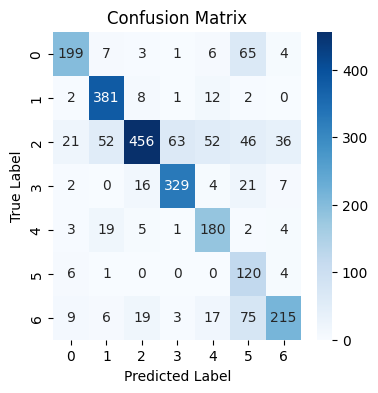

In [49]:
visiting_freq_label = pagerank_model_fast(
    train,
    0, # teleportation probability
    seeds_dict, 
    walk_probs_uniform, # uniform
    num_classes, # 7 classes
    num_samples, # 1000 samples
    num_walk_steps # 100 steps
)

Running walks:   0%|          | 0/140 [00:00<?, ?it/s]

Personalized PageRank Random Walk with teleportation and TF-IDF-based transition
Teleportation probability: 0.1
Number of unvisited nodes: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       285
           1       0.82      0.91      0.86       406
           2       0.85      0.63      0.72       726
           3       0.83      0.81      0.82       379
           4       0.58      0.81      0.67       214
           5       0.45      0.89      0.60       131
           6       0.71      0.65      0.68       344

    accuracy                           0.74      2485
   macro avg       0.72      0.77      0.73      2485
weighted avg       0.77      0.74      0.75      2485

Accuracy: 0.7449
Weighted F1 Score: 0.7478
Elapsed Time: 85.31 seconds


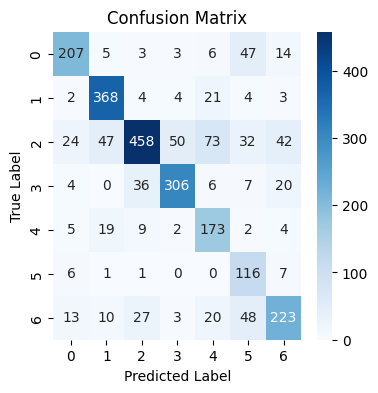

In [50]:
visiting_freq_label = pagerank_model_fast(
    train,
    0.1, # teleportation probability
    seeds_dict, 
    walk_probs_uniform, # uniform
    num_classes, # 7 classes
    num_samples, # 1000 samples
    num_walk_steps # 100 steps
)

Running walks:   0%|          | 0/140 [00:00<?, ?it/s]

Personalized PageRank Random Walk with teleportation and TF-IDF-based transition
Teleportation probability: 0.2
Number of unvisited nodes: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       285
           1       0.82      0.90      0.86       406
           2       0.83      0.59      0.69       726
           3       0.80      0.79      0.80       379
           4       0.54      0.80      0.65       214
           5       0.47      0.86      0.61       131
           6       0.69      0.65      0.67       344

    accuracy                           0.73      2485
   macro avg       0.70      0.76      0.72      2485
weighted avg       0.75      0.73      0.73      2485

Accuracy: 0.7276
Weighted F1 Score: 0.7289
Elapsed Time: 80.79 seconds


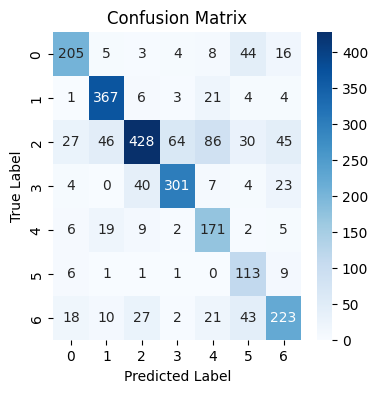

In [51]:
visiting_freq_label = pagerank_model_fast(
    train,
    0.2, # teleportation probability
    seeds_dict, 
    walk_probs_uniform, # uniform
    num_classes, # 7 classes
    num_samples, # 1000 samples
    num_walk_steps # 100 steps
)

Running walks:   0%|          | 0/140 [00:00<?, ?it/s]

Personalized PageRank Random Walk with teleportation and TF-IDF-based transition
Teleportation probability: 0
Number of unvisited nodes: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       285
           1       0.81      0.94      0.87       406
           2       0.88      0.61      0.72       726
           3       0.83      0.83      0.83       379
           4       0.64      0.84      0.73       214
           5       0.36      0.94      0.52       131
           6       0.76      0.61      0.68       344

    accuracy                           0.74      2485
   macro avg       0.73      0.78      0.73      2485
weighted avg       0.79      0.74      0.75      2485

Accuracy: 0.7441
Weighted F1 Score: 0.7509
Elapsed Time: 93.93 seconds


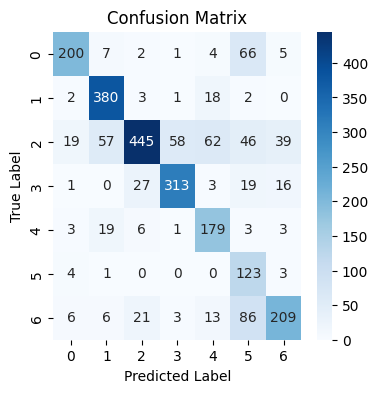

In [52]:
visiting_freq_label = pagerank_model_fast(
    train,
    0, # teleportation probability
    seeds_dict, 
    walk_probs_cosine, # TF-IDF-like
    num_classes, # 7 classes
    num_samples, # 1000 samples
    num_walk_steps # 100 steps
)

Running walks:   0%|          | 0/140 [00:00<?, ?it/s]

Personalized PageRank Random Walk with teleportation and TF-IDF-based transition
Teleportation probability: 0.1
Number of unvisited nodes: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       285
           1       0.83      0.91      0.87       406
           2       0.85      0.64      0.73       726
           3       0.83      0.81      0.82       379
           4       0.59      0.82      0.68       214
           5       0.45      0.86      0.59       131
           6       0.71      0.65      0.68       344

    accuracy                           0.75      2485
   macro avg       0.72      0.77      0.73      2485
weighted avg       0.77      0.75      0.75      2485

Accuracy: 0.7465
Weighted F1 Score: 0.7495
Elapsed Time: 89.78 seconds


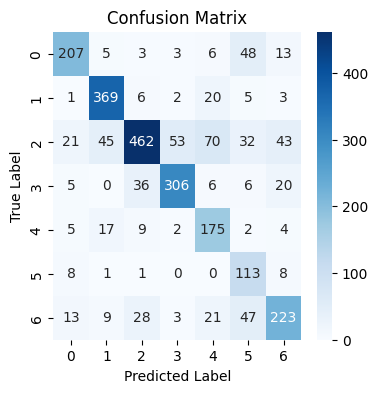

In [53]:
visiting_freq_label = pagerank_model_fast(
    train,
    0.1, # teleportation probability
    seeds_dict, 
    walk_probs_cosine, # TF-IDF-like
    num_classes, # 7 classes
    num_samples, # 1000 samples
    num_walk_steps # 100 steps
)

Running walks:   0%|          | 0/140 [00:00<?, ?it/s]

Personalized PageRank Random Walk with teleportation and TF-IDF-based transition
Teleportation probability: 0.2
Number of unvisited nodes: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       285
           1       0.81      0.90      0.86       406
           2       0.84      0.59      0.70       726
           3       0.82      0.79      0.80       379
           4       0.54      0.79      0.64       214
           5       0.48      0.88      0.62       131
           6       0.68      0.65      0.67       344

    accuracy                           0.73      2485
   macro avg       0.71      0.76      0.72      2485
weighted avg       0.76      0.73      0.73      2485

Accuracy: 0.7300
Weighted F1 Score: 0.7318
Elapsed Time: 79.40 seconds


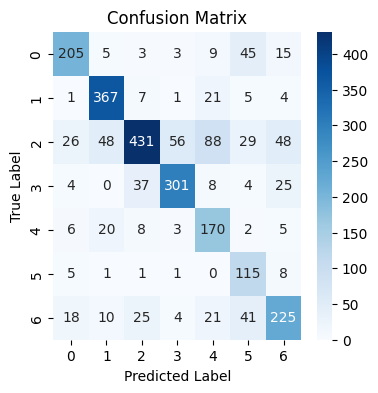

In [54]:
visiting_freq_label = pagerank_model_fast(
    train,
    0.2, # teleportation probability
    seeds_dict, 
    walk_probs_cosine, # TF-IDF-like
    num_classes, # 7 classes
    num_samples, # 1000 samples
    num_walk_steps # 100 steps
)

### Debug

In [55]:
print("Type:", type(visiting_freq_label))
print("Shape:", np.shape(visiting_freq_label))

Type: <class 'numpy.ndarray'>
Shape: (2485, 7)


In [56]:
import numpy as np
np.set_printoptions(suppress=True, precision=0)
print("Class-wise total visit count:")
print(np.sum(visiting_freq_label, axis=0))

Class-wise total visit count:
[2000000. 2000000. 2000000. 2000000. 2000000. 2000000. 2000000.]


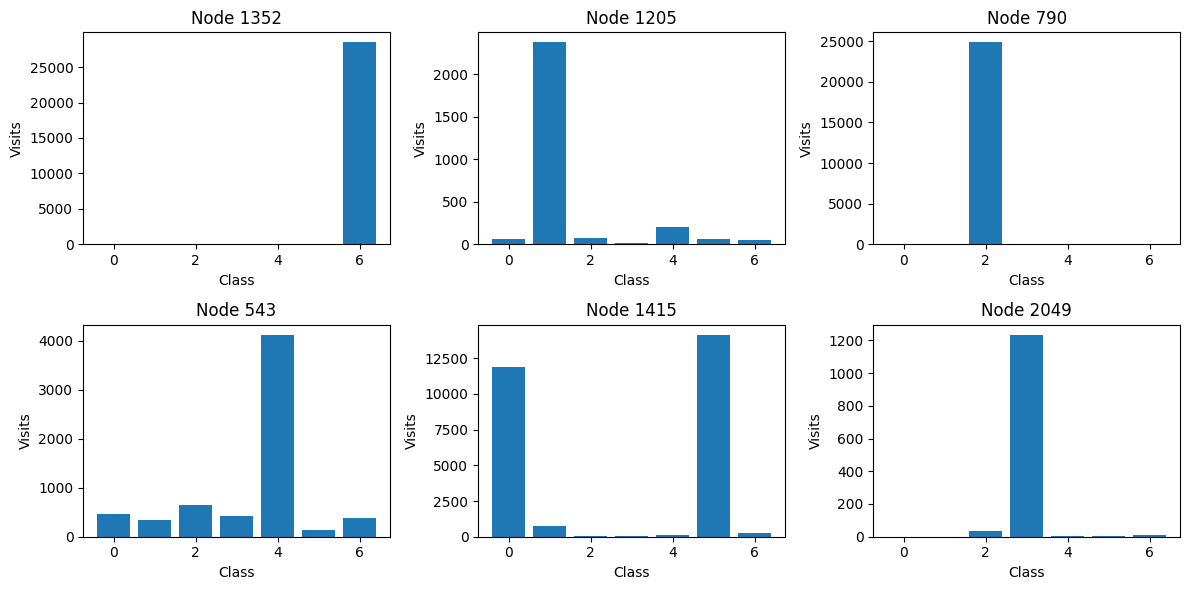

In [57]:
import matplotlib.pyplot as plt
import numpy as np

visiting_freq_label = np.array(visiting_freq_label)
num_classes = visiting_freq_label.shape[1]

sample_idx = np.random.choice(range(visiting_freq_label.shape[0]), 6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()  # ✅ flatten to use axes[i]

for i, node_idx in enumerate(sample_idx):
    axes[i].bar(range(num_classes), visiting_freq_label[node_idx])
    axes[i].set_title(f"Node {node_idx}")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Visits")

plt.tight_layout()
plt.show()

In [58]:
import numpy as np
print("Class-wise total visit count:")
print(np.sum(visiting_freq_label, axis=0))

for label in range(7):
    topk = visiting_freq_label[:, label].argsort()[-5:][::-1]
    print(f"Top nodes for class {label}:")
    for node in topk:
        print(f"  Node {node}: visits = {visiting_freq_label[node]}, predicted = {np.argmax(visiting_freq_label[node])}")

Class-wise total visit count:
[2000000. 2000000. 2000000. 2000000. 2000000. 2000000. 2000000.]
Top nodes for class 0:
  Node 1999: visits = [54174.    13.    32.   963.    66.   113.   100.], predicted = 0
  Node 273: visits = [43839.   180.    39.    13.    59.  1372.    35.], predicted = 0
  Node 65: visits = [42577.   148.   171.  2816.   777.  1350.  1258.], predicted = 0
  Node 1445: visits = [38556.    49.    11.     5.    18.   248.     7.], predicted = 0
  Node 1277: visits = [37330.   735.   111.   335.   130.  2840.   334.], predicted = 0
Top nodes for class 1:
  Node 159: visits = [  3536. 118929.   1988.   2170.  14663.   3189.   4849.], predicted = 1
  Node 1713: visits = [   14. 36136.    23.     9.    56.    19.    21.], predicted = 1
  Node 2071: visits = [   13. 35246.    11.     7.    42.    10.    22.], predicted = 1
  Node 493: visits = [ 4239. 31581. 11576.  1037. 11484.   805.  1059.], predicted = 1
  Node 126: visits = [  180. 30655.   193.    59.   558.   118.  

In [59]:
print(visiting_freq_label[0])
print(visiting_freq_label.sum())  # 总访问次数

import numpy as np

node_totals = visiting_freq_label.sum(axis=1)
top_nodes = np.argsort(-node_totals)[:10]

for node in top_nodes:
    print(f"Node {node}: Total visits = {node_totals[node]}, Label distribution = {visiting_freq_label[node]}")

[  63.   11. 2355.   79.   33.   21.  534.]
14000000.0
Node 159: Total visits = 149324.0, Label distribution = [  3536. 118929.   1988.   2170.  14663.   3189.   4849.]
Node 533: Total visits = 114813.0, Label distribution = [ 5179.  5221. 14985.  3925. 76188.  1466.  7849.]
Node 324: Total visits = 103666.0, Label distribution = [ 4063.   343.  1062.   672.   380. 82076. 15070.]
Node 493: Total visits = 61781.0, Label distribution = [ 4239. 31581. 11576.  1037. 11484.   805.  1059.]
Node 2245: Total visits = 59057.0, Label distribution = [  834.   194.   167.   114.   153. 55751.  1844.]
Node 520: Total visits = 57568.0, Label distribution = [ 1824.  1444.  2558.  2441. 46612.   846.  1843.]
Node 401: Total visits = 55543.0, Label distribution = [ 2164.   148.   390.   406.   135. 36775. 15525.]
Node 1999: Total visits = 55461.0, Label distribution = [54174.    13.    32.   963.    66.   113.   100.]
Node 789: Total visits = 49756.0, Label distribution = [  128.   617.    19.    13.  

In [60]:
def analyze_feature_quality(df_gcc, train_df):
    X = np.stack(df_gcc.sort_values("node")["features"].values)
    y = df_gcc.sort_values("node")["label"].values
    mask = ~df_gcc["node"].isin(train_df["node"])

    X_train = X[train_df["node"].values]
    y_train = train_df["label"].values
    X_test = X[mask.values]
    y_test = y[mask.values]

    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"✅ Logistic regression accuracy (no graph): {acc:.4f}")

def analyze_seed_degrees(G, seeds_dict):
    degrees = {node: G.degree(node) for node in G.nodes()}
    print("\n Seed node degree per class:")
    for label in range(7):
        class_degrees = [degrees[node] for node in seeds_dict[label]]
        print(f"Class {label}: mean={np.mean(class_degrees):.1f}, min={np.min(class_degrees)}, max={np.max(class_degrees)}")

def analyze_prediction_confidence(visiting_freq_label):
    visiting_freq_label = np.array(visiting_freq_label)
    entropies = []
    for row in visiting_freq_label:
        p = row / row.sum() if row.sum() > 0 else np.ones_like(row) / len(row)
        entropy = -np.sum(p * np.log(p + 1e-9)) 
        entropies.append(entropy)
    print(f"\n Avg entropy of visit distributions: {np.mean(entropies):.4f} (higher = more uncertain)")
    sns.histplot(entropies, bins=30, kde=True)
    plt.title("Distribution of Visit Entropies")
    plt.xlabel("Entropy")
    plt.ylabel("Node count")
    plt.show()

def analyze_cosine_distribution(df_gcc, G):
    features = np.stack(df_gcc.sort_values("node")["features"].values)
    normed = features / np.linalg.norm(features, axis=1, keepdims=True)

    all_sims = []
    for u in G.nodes():
        for v in G.neighbors(u):
            sim = np.dot(normed[u], normed[v])
            all_sims.append(sim)

    print(f"\n Cosine similarity range: min={np.min(all_sims):.3f}, mean={np.mean(all_sims):.3f}, max={np.max(all_sims):.3f}")
    sns.histplot(all_sims, bins=30, kde=True)
    plt.title("Cosine Similarity Distribution (neighbors only)")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")
    plt.show()

✅ Logistic regression accuracy (no graph): 0.6085

 Seed node degree per class:
Class 0: mean=3.5, min=1, max=17
Class 1: mean=5.0, min=1, max=30
Class 2: mean=4.2, min=2, max=18
Class 3: mean=4.2, min=1, max=12
Class 4: mean=3.9, min=1, max=11
Class 5: mean=4.2, min=2, max=15
Class 6: mean=3.5, min=1, max=10

 Avg entropy of visit distributions: 0.8352 (higher = more uncertain)


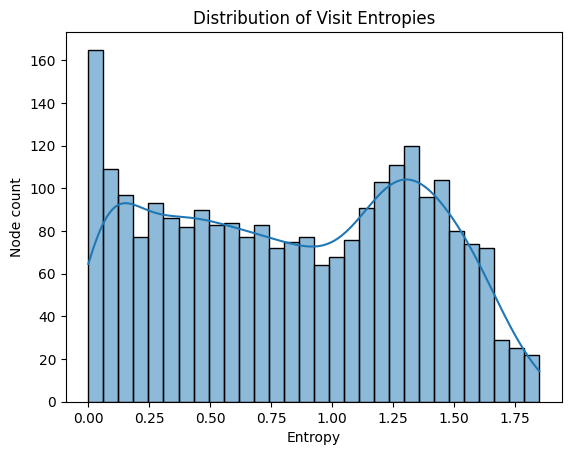


 Cosine similarity range: min=0.000, mean=0.166, max=1.000


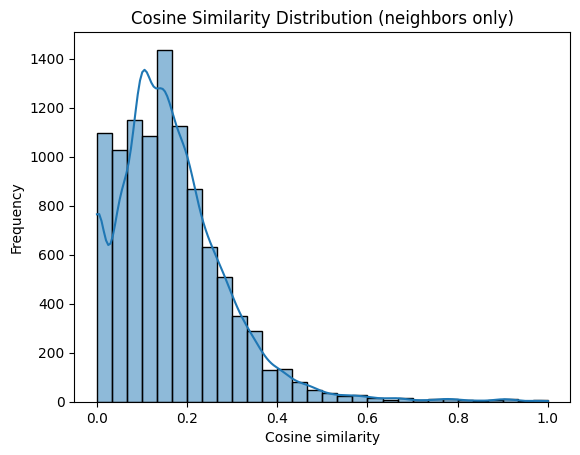

In [62]:
analyze_feature_quality(gcc_df, train)
analyze_seed_degrees(gcc, seeds_dict)
analyze_prediction_confidence(visiting_freq_label)
analyze_cosine_distribution(gcc_df, gcc)

### Answer

| Teleport α | Transition Type                 | Accuracy | Macro F1 |
|------------|----------------------------------|----------|----------|
| 0.0        | Uniform Probability              | 74.69%   | 75.25%   |
| 0.1        | Uniform Probability              | 74.00%   | 74.23%   |
| 0.2        | Uniform Probability              | 73.16%   | 78.07%   |
| 0.0        | Cosine Similarity (TF-IDF-like)  | 75.01%   | 75.64%   |
| 0.1        | Cosine Similarity (TF-IDF-like)  | 74.16%   | 74.40%   |
| 0.2        | Cosine Similarity (TF-IDF-like)  | 73.28%   | 73.45%   |

Analysis:

We evaluate the performance of personalized PageRank with two transition strategies—uniform probability and cosine similarity (TF-IDF-like)—under three teleportation probabilities (α = 0.0, 0.1, 0.2). Experiments are conducted on the Cora dataset, which is a citation graph where nodes represent documents and edges denote citation links.

Our results show that:
- When α = 0.0 (no teleportation), the model achieves the highest accuracy for both transition types. This is consistent with the nature of the Cora graph, where nodes of the same class are often connected locally (high homophily).
- The cosine similarity strategy slightly outperforms uniform probability at α = 0.0, indicating that feature similarity helps guide walks toward semantically similar nodes.
- However, when α increases (more teleportation), performance drops, especially for cosine similarity, likely because teleportation introduces noise and disrupts the structural flow of walks.
- Interestingly, macro F1 is highest with uniform probability at α = 0.2, suggesting that uniform walks with more teleportation improve recall on smaller or less-connected classes, even if overall accuracy decreases.

These findings suggest that while cosine similarity provides meaningful local guidance, pure structural exploration (α = 0) is most effective on Cora. In high teleportation settings, uniform walks may help alleviate class imbalance by improving fairness across categories.